# Detection of microscope damaged/outside parts
Autor: Jose Miguel Serra Lleti


This notebook belongs to the article:______________

In this notebook, we train a CNN on augmented images from two different regions: inside and damaged/outside microscope. We call them terrains.  A good terrain is INSIDE the sample area, a bad terrain is OUTSIDE the sample area or a DAMAGED region. The problem is equivalent to classify textures and a simple Convolutional Neural Network can help us to achieve classify them.
The classifier is trained to differentiate then between the 2 types of objects. 
- "crosses" or "terrain" : class 0
- "out" : class 1

The procedure is quite standard in the Deep Learning computer vision world:
   - Obtain data based on crops
   - Augment data
   - Make a category, i.e., assign a label to each patch (0 or 1)
   - Load a classifier with pretrained weights. We will use a DenseNet121 https://keras.io/api/applications/densenet/#densenet121-function
   - Retrain the netwok.
   
  

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 
from shutil import copyfile
from tqdm import tqdm
import glob
import os

In [2]:
from keras import backend as K
import tensorflow as tf
from imp import reload
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:       
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPU


In [3]:
# MODIFY THIS: folder with TERRAIN
# Prepare a list with all files corresponding to terrain (not crosses)
dirSample = ".\\data"
terrain = glob.glob(dirSample+"\\valid\\*.tif")

In [4]:
# MODIFY THIS: folder with OUT
# Prepare a list with all files corresponding to OUT
dirSample = ".\\data"
out = glob.glob(dirSample+"\\not_valid\\*.tif")

In [5]:
# PART 1: READ images
# PREPROCESSING: enhance contrast,normalization between 0-1
# Functions to prepare images

from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from skimage.morphology import disk
from skimage.filters.rank import mean_bilateral
from skimage.filters.rank import enhance_contrast_percentile

# All images are preprocessed for unbalanced brightness and contrast and resized to 128 by 128
def preprocess(image):
    # Local contrast enhancement
    enh = enhance_contrast_percentile(image, disk(3), p0=.1, p1=.9)
    image = cv2.resize(enh, (256, 256)) 
    final = np.array(image,dtype=np.float32)
    return final


def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    img = preprocess(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 1) and return 4D tensor    
    return np.expand_dims(img, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [6]:
# We need balanced classes
total_good  = len(terrain)
total_bad = len(out)
print('We have a total of terrain : '+str(total_good)+" and a total of outs :"+str(total_bad))

We have a total of terrain : 452 and a total of outs :422


In [7]:
# Read bad tensors
tout = paths_to_tensor(out)

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:33<00:00, 12.63it/s]


In [8]:
# Augment until 3000
import imgaug as ia
import random
from imgaug import augmenters as iaa

ia.seed(5)

# Amplify train_tensors
list_of_tensors_out = []
inc = int(1500/total_bad)
for i in range (inc):
    for ind,tensor in enumerate(tout):
        img_or = tout[ind,:,:]
        seq = iaa.SomeOf(2,[
            iaa.Fliplr(1.0), # horizontal flips
            iaa.Flipud(1.0),# vertical flips
            iaa.Invert(1.0), # change brightness
            iaa.Add((-20,20)),
            iaa.Multiply((0.9,1.5)),
            iaa.Affine(rotate=(-5,5),scale=(0.9, 1.1))])

        seq_det = seq.to_deterministic()

        # Augment keypoints and images.
        image_aug = seq_det.augment_images([img_or])[0]
        ntensor = np.expand_dims(image_aug, axis=0)
        ntensor = np.uint8(ntensor)
        list_of_tensors_out.append(ntensor)


In [9]:
# Prepare the data. Make them color because we will use a pretrained Resnet18 with 3 channels
list_of_tensors_out_total =  np.vstack([tout,np.squeeze(list_of_tensors_out)])
indexes = list(range(list_of_tensors_out_total.shape[0]))
list_of_tensors_bad =  np.array([ (cv2.cvtColor(list_of_tensors_out_total[i],cv2.COLOR_GRAY2RGB)-127.)/128. for i in indexes])
total = list_of_tensors_bad.shape
list_of_bad = np.zeros((total[0],1))+1

In [10]:
terrain = paths_to_tensor(terrain)

100%|████████████████████████████████████████████████████████████████████████████████| 452/452 [00:25<00:00, 17.71it/s]


In [11]:
import imgaug as ia
import random
from imgaug import augmenters as iaa

ia.seed(7)

inc = int(1500/total_good)
list_of_tensors_terrain = []
for i in range(inc):
    for ind,tensor in enumerate(terrain):
        img_or = terrain[ind,:,:]
        seq = iaa.SomeOf(2,[
            iaa.Fliplr(1.0), # horizontal flips
            iaa.Flipud(1.0),# vertical flips
            iaa.Invert(1.0), # change brightness
            iaa.Add((-20,20)),
            iaa.Multiply((0.9,1.2)),
            iaa.Affine(rotate=(-5,5),scale=(0.9, 1.1))])

        seq_det = seq.to_deterministic()

        # Augment keypoints and images.
        image_aug = seq_det.augment_images([img_or])[0]

        ntensor = np.expand_dims(image_aug, axis=0)
        ntensor = np.uint8(ntensor)
        list_of_tensors_terrain.append(ntensor)

In [12]:
# Same for good
list_of_tensors_good =  np.vstack([terrain,np.squeeze(list_of_tensors_terrain)])
indexes = list(range(list_of_tensors_good.shape[0]))
list_of_tensors_good = np.array([ (cv2.cvtColor(list_of_tensors_good[i],cv2.COLOR_GRAY2RGB)-127.)/128. for i in indexes])
total = list_of_tensors_good.shape
list_of_good = np.zeros((total[0],1))

In [13]:
# Generate a stack convert them to categories
from keras.utils import np_utils
f_train =np.vstack([list_of_tensors_bad,list_of_tensors_good])
y_train = np.vstack([list_of_bad, list_of_good])
class_targets = np_utils.to_categorical(y_train, 2)

Put all data together and shuffle :

In [14]:
indexes = list(range(f_train.shape[0]))
random.shuffle(indexes)
f_train_tensors = np.array([ f_train[i] for i in indexes])
f_class_targets = np.array([ class_targets[i] for i in indexes])

In [15]:
f_train_tensors.shape

(3496, 256, 256, 3)

In [16]:
# How many outside/damaged?
total_bad = np.sum(np.argmax(f_class_targets,axis=1)==1)
total_bad

1688

In [17]:
# Split in train, test. Dev will be used as % of train
x_train, x_test, y_train, y_test = train_test_split(f_train_tensors, f_class_targets , test_size=0.1, random_state=1)

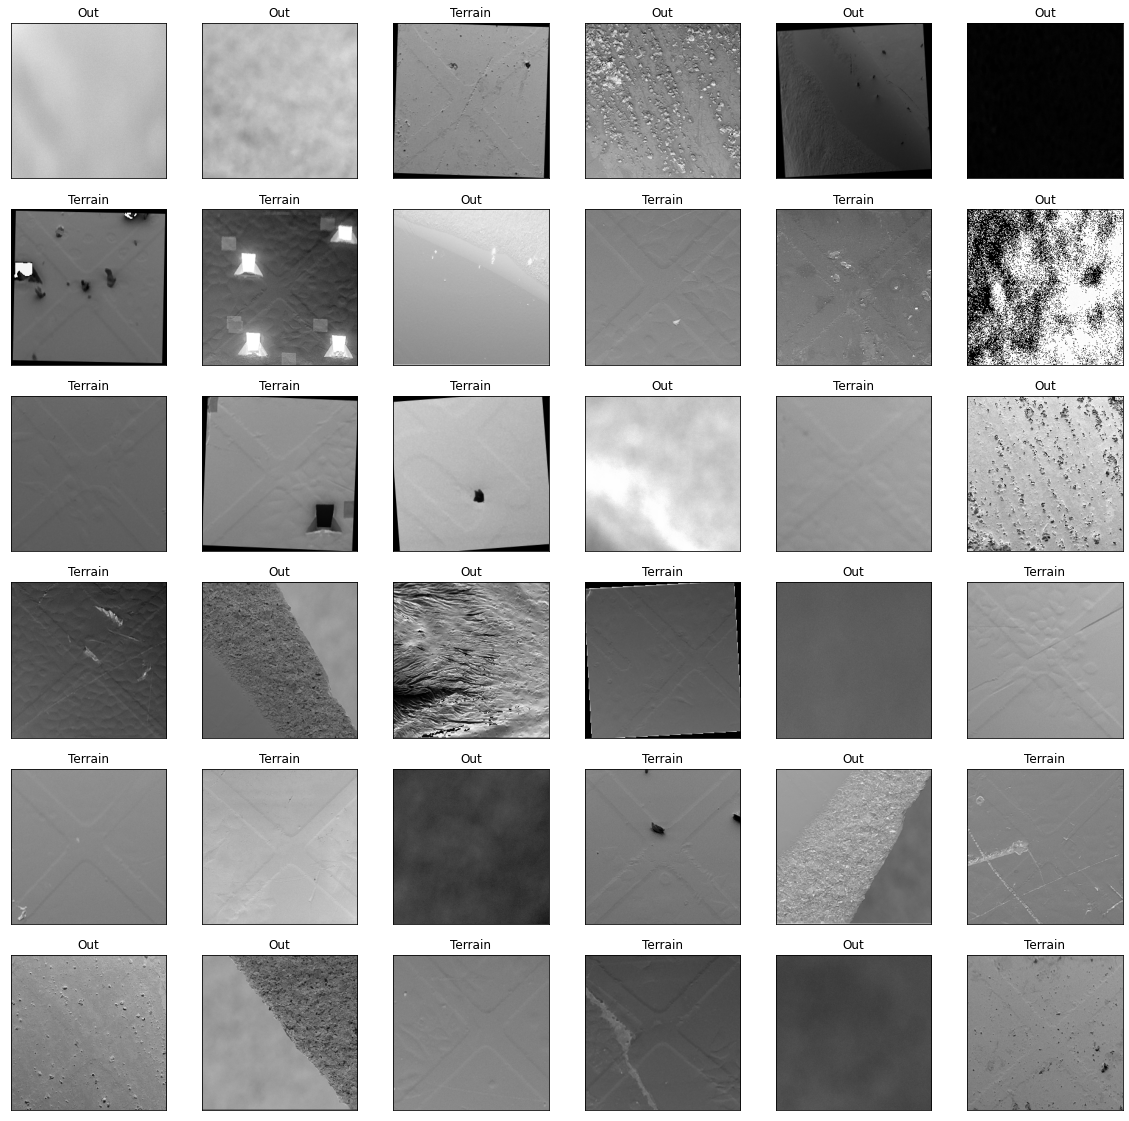

In [18]:
# Check the images
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,20))
for i in range(36):
    ix = i+1000
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    img = f_train_tensors[ix,:,:]
    ax.imshow(np.uint8(np.squeeze((img)*128)+127))
    if(np.argmax(f_class_targets[ix])==0):
        ax.set_title("Terrain")
    else:
        ax.set_title("Out")
        

In [19]:
### TODO: Define your architecture
from keras.applications import DenseNet121
from keras.layers import Dense
from keras.models import Model


In [20]:
DN121_model_no_top =  DenseNet121(weights='imagenet', include_top=False, pooling ='avg',input_shape=(256, 256, 3))

In [21]:
#for layer in DN121_model_no_top.layers:
#    layer.trainable = False

x = DN121_model_no_top.output
x = Dense(2, activation='softmax')(x)
DN121_model = Model(inputs=DN121_model_no_top.input,outputs = x)

DN121_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [22]:
x_train = np.squeeze(x_train)
x_train = np.expand_dims(x_train, axis=3)

In [23]:
## TODO: Save the model as model.h5
nmodel_json = DN121_model.to_json()
with open("model_TERRAIN_DN121.json", "w") as json_file:
    json_file.write(nmodel_json)
print("Saved model to disk")

Saved model to disk


In [24]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
optim =  Adam(lr = 1e-3)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
DN121_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
y_train.shape
x_train = np.squeeze(x_train)
x_train.shape

(3146, 256, 256, 3)

In [26]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.best_terrain_DN121.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist = DN121_model.fit(
        x_train, np.array(y_train),      
        validation_split=0.2,
        #validation_data = (valid_tensors,y_valid),
        batch_size = 20,
        epochs=50,
        verbose =1,
        callbacks = [checkpointer, reduce_lr, early_stop])


Train on 2516 samples, validate on 630 samples
Epoch 1/50
2516/2516 [==============================] - 102s 40ms/step - loss: 0.3238 - accuracy: 0.8824 - val_loss: 0.7250 - val_accuracy: 0.9032

Epoch 00001: val_loss improved from inf to 0.72503, saving model to weights.best_terrain_DN121.from_scratch.hdf5
Epoch 2/50
2516/2516 [==============================] - 62s 25ms/step - loss: 0.1709 - accuracy: 0.9372 - val_loss: 4.9087 - val_accuracy: 0.8270

Epoch 00002: val_loss did not improve from 0.72503
Epoch 3/50
2516/2516 [==============================] - 61s 24ms/step - loss: 0.1405 - accuracy: 0.9479 - val_loss: 0.1639 - val_accuracy: 0.9476

Epoch 00003: val_loss improved from 0.72503 to 0.16390, saving model to weights.best_terrain_DN121.from_scratch.hdf5
Epoch 4/50
2516/2516 [==============================] - 61s 24ms/step - loss: 0.1658 - accuracy: 0.9380 - val_loss: 0.2910 - val_accuracy: 0.9095

Epoch 00004: val_loss did not improve from 0.16390
Epoch 5/50
2516/2516 [==========

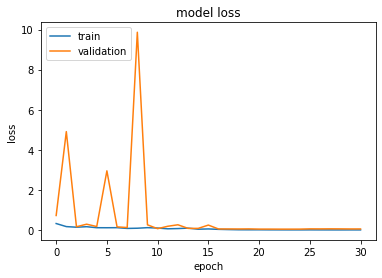

In [29]:
## TODO: Visualize the training and validation loss of your neural network
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model error')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./loss_curve.png')


plot_learning_curve(hist)

 Now, we test our classifier:

In [30]:
from keras.models import model_from_json
json_file = open('model_TERRAIN_DN121.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
nmodel = model_from_json(loaded_model_json)
nmodel.load_weights('weights.best_terrain_DN121.from_scratch.hdf5')

In [31]:
p_test = nmodel.predict(x_test)

In [32]:
x_test.shape

(350, 256, 256, 3)

In [33]:
pred = np.argmax(y_test, axis=1)
print(pred[0:50])

[1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1]


In [34]:
predictions = np.argmax(p_test,axis=1)
# report test accuracy
test_accuracy = 100*np.sum(predictions==np.argmax(y_test, axis=1))/len(y_test)
print('Test accuracy : %.4f%%' % test_accuracy)

Test accuracy : 99.4286%


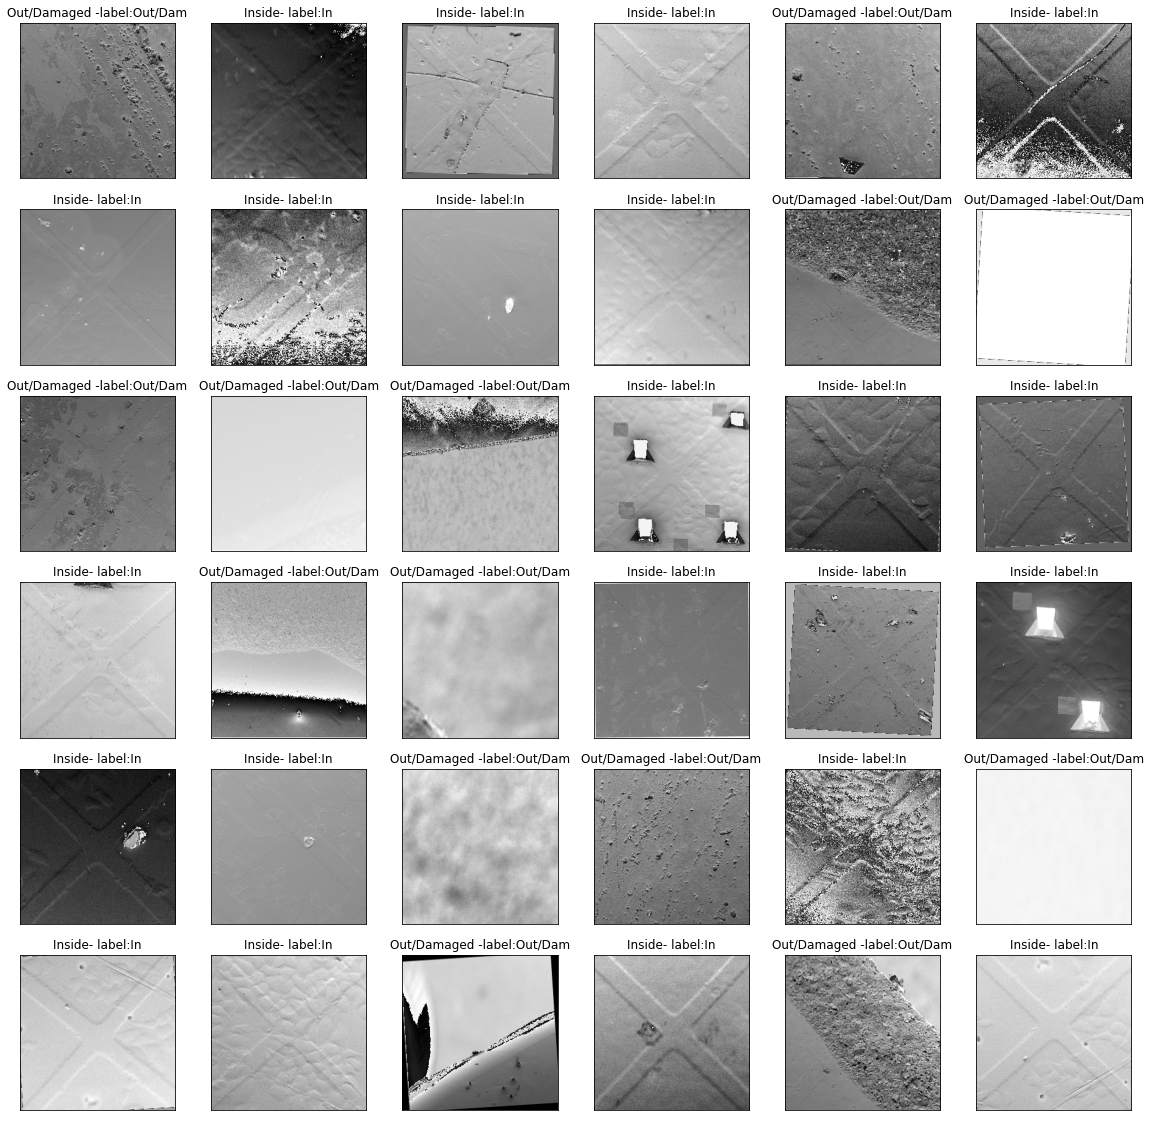

In [42]:
# load the weights that yielded the best validation accuracy
fig2 = plt.figure(figsize=(20,20))
for ix in range(36):
    ax2 = fig2.add_subplot(6, 6, ix+1, xticks=[], yticks=[])
    img = x_test[ix,:,:]
    ax2.imshow(np.squeeze(np.uint8((img/np.max(img))*128 +127)))
    if pred[ix]==0 :
        sol = "In"
    else:
        sol = "Out/Dam"
    if(predictions[ix]==0):
        ax2.set_title("Inside- label:"+sol)
    else:
        ax2.set_title("Out/Damaged -label:"+sol)

Second, now we try with data from a SCAN and test the model:

In [57]:
# Load TEST
dirSample = ".\\data\\TEST\\*.tif"
sample_test = glob.glob(dirSample)

In [58]:
test_tensors2 = paths_to_tensor(sample_test)

100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:07<00:00, 16.42it/s]


In [59]:
test_tensors2 = np.array([ (cv2.cvtColor(el, cv2.COLOR_GRAY2RGB)-127.) /128. for el in test_tensors2])
p_test2= nmodel.predict(test_tensors2)

In [60]:
predictions = np.argmax(p_test2,axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

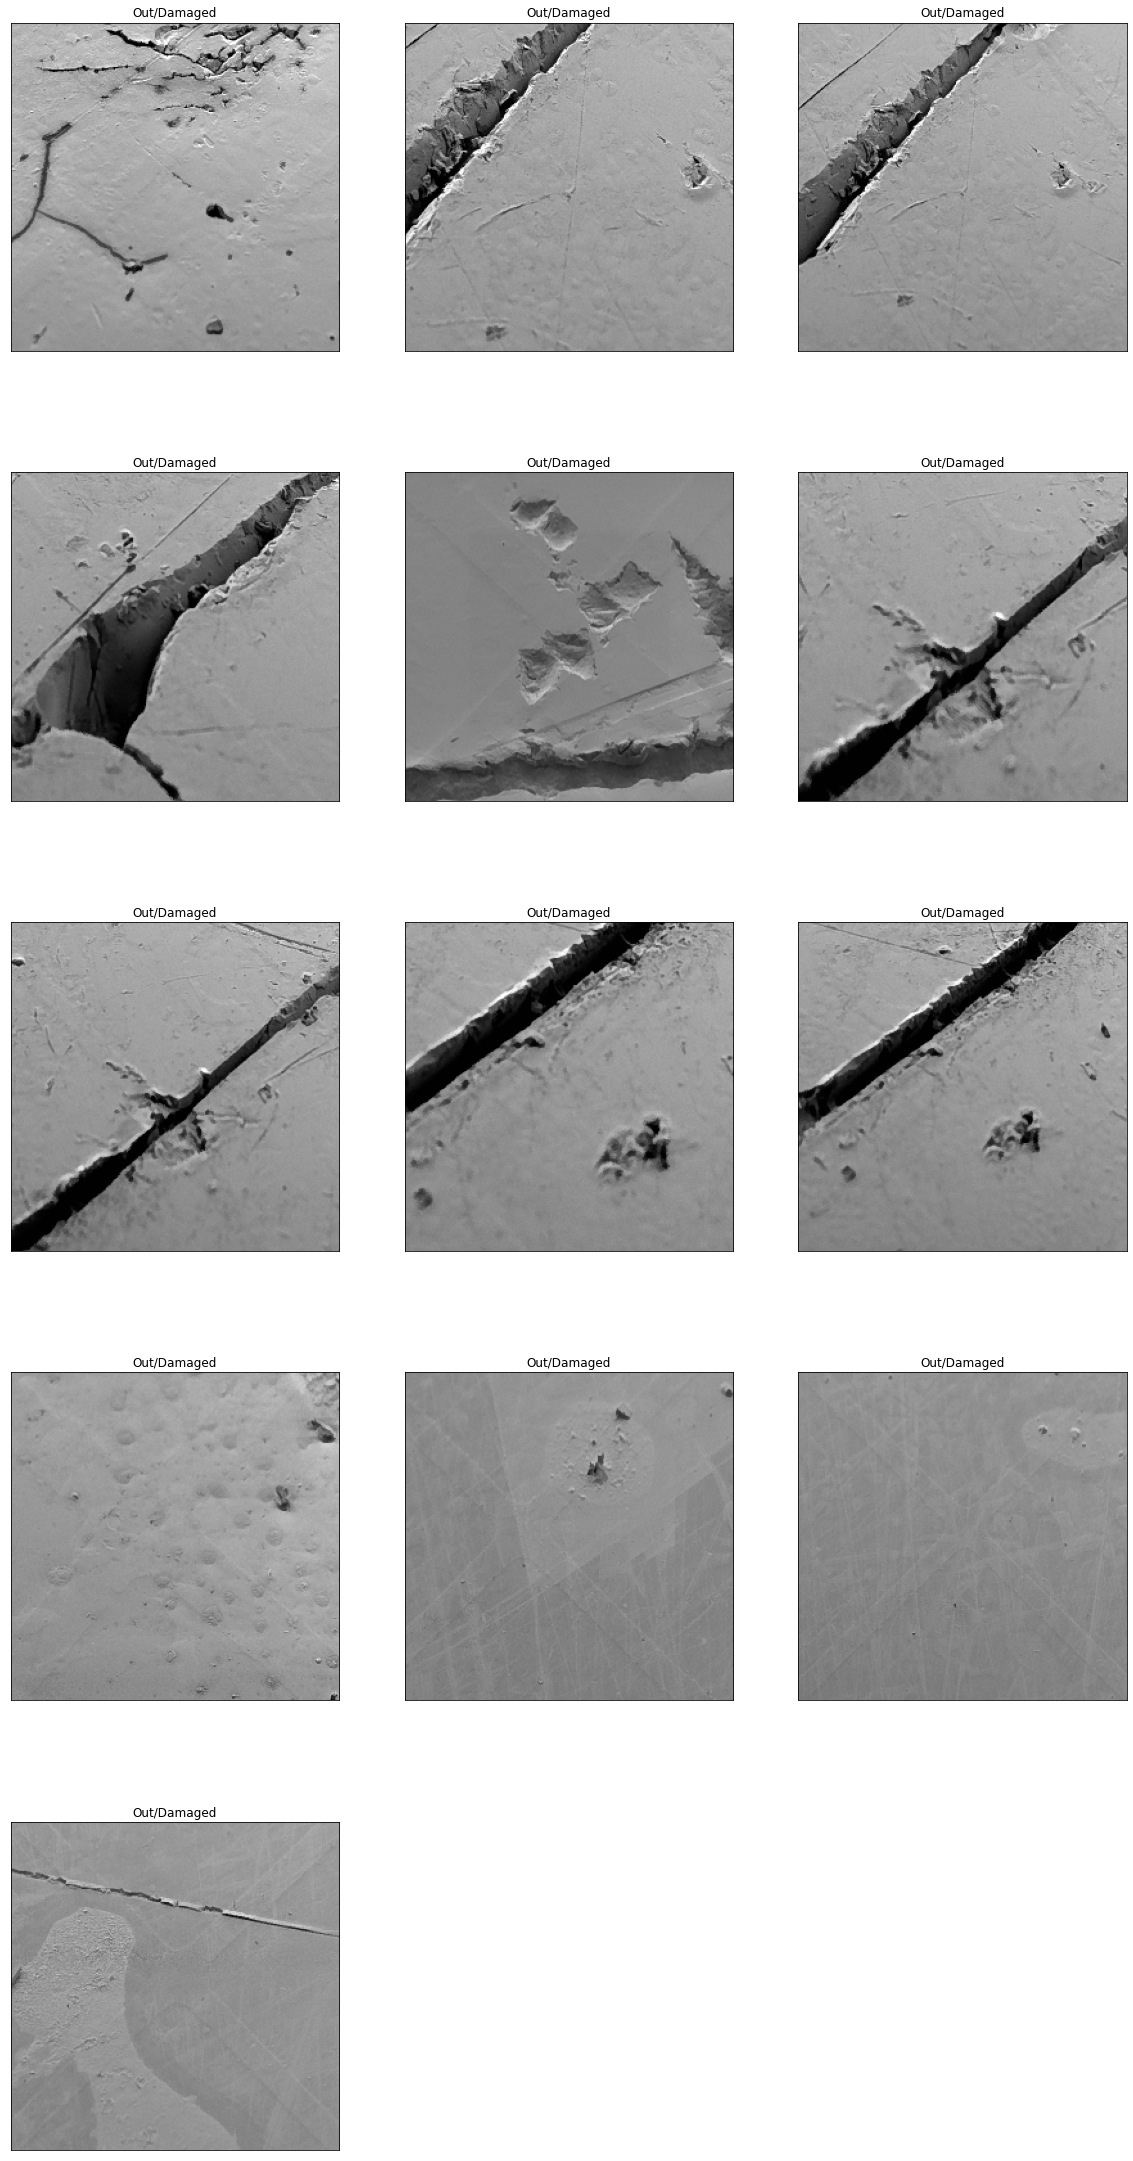

In [71]:
# load the weights that yielded the best validation accuracy
fig2 = plt.figure(figsize=(20,40))
i = 0
for ix in range(len(predictions)):
    if(predictions[ix]!=0):
        ax2 = fig2.add_subplot(5,3, i+1, xticks=[], yticks=[])
        img = test_tensors2[ix,:,:,:]
        ax2.imshow(np.squeeze(np.uint8((img)*128 +127)))
        ax2.set_title("Out/Damaged")
        i = i+1